In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import time
import math
import mpmath
import sympy as sym

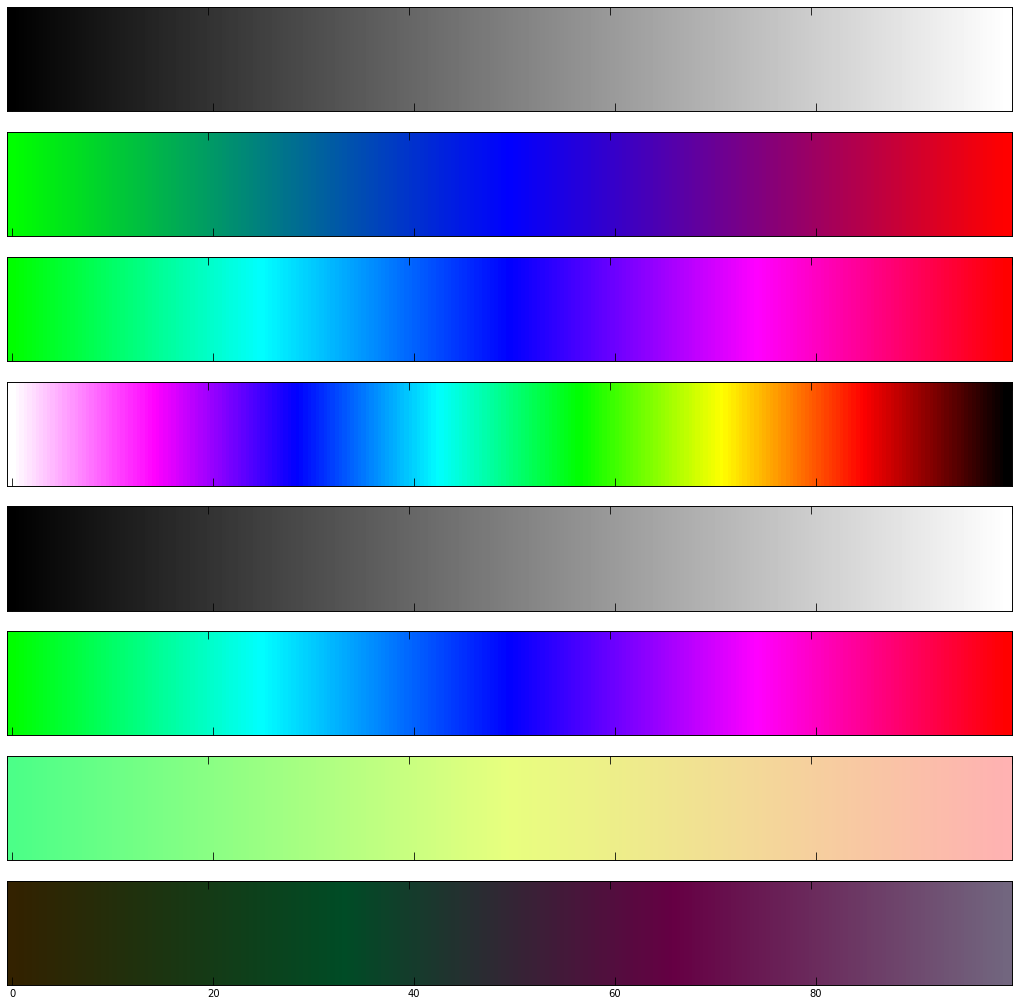

In [2]:
def list_to_dict(lees):
    ln=len(lees)
    r=[]
    g=[]
    b=[]    
    
    for i, x in enumerate(lees):
        m=int(x[1:3], 16)
        r.append((i/(ln-1), m/255, m/255))
        
        m=int(x[3:5], 16)
        g.append((i/(ln-1), m/255, m/255))
        
        m=int(x[5:7], 16)
        b.append((i/(ln-1), m/255, m/255))
    return {'red':r, 'green':g, 'blue':b}

def hsv2rgb(h, s, v):
    c=s*v
    x=c*(1-abs((h/60)%2-1))
    m=v-c            
    
    if (h<60):
        tt=c, x, 0
    elif (h<120):
        tt=x, c, 0
    elif (h<180):
        tt=0, c, x
    elif (h<240):
        tt=0, x, c
    elif (h<300):
        tt=x, 0, c
    else:
        tt=c, 0, x
    tt=(int((tt[0]+m)*255), int((tt[1]+m)*255), int((tt[2]+m)*255))
    
    return tt

def tuptovalid(tt):
    r=hex(tt[0])[2:].upper()
    g=hex(tt[1])[2:].upper()
    b=hex(tt[2])[2:].upper()
    
    r=r if (len(r)==2) else '0'+r
    g=g if (len(g)==2) else '0'+g
    b=b if (len(b)==2) else '0'+b
    return '#'+r+g+b
    

fig, ax=plt.subplots(8,1,figsize=(18,18))

for i in range(8):
    ax[i].set_yticks([])
    if (i!=7):
        ax[i].set_xticklabels([])
    ax[i].tick_params(direction='in', length=8)
    ff=ax[i].twiny()
    
    ff.set_xticklabels([])
    ff.tick_params(direction='in', length=8)

s=np.arange(0, 1, 0.01)
s=np.reshape(s, (1, len(s)))

hsv=[0]*4
hsv[0]=[(0, 0, 0), (0, 0, 1)]
hsv[1]=[((120+i*60)%360, 1, 1) for i in range(5)]
hsv[2]=[(140, 0.7, 1), (70, 0.5, 1), (0, 0.3, 1)]
hsv[3]=[(40, 1, 0.2), (150, 1, 0.3), (320, 1, 0.4), (270, 0.2, 0.5)]

cdict=[0]*8
cdict[0]=list_to_dict(['#000000', '#FFFFFF'])
cdict[1]=list_to_dict(['#00FF00', '#0000FF', '#FF0000'])
cdict[2]=list_to_dict(['#00FF00', '#00FFFF', '#0000FF', '#FF00FF', '#FF0000'])
cdict[3]=list_to_dict(['#FFFFFF', '#FF00FF', '#0000FF', '#00FFFF', '#00FF00', '#FFFF00', '#FF0000', '#000000'])

for i in range(4, 4+len(hsv)):
    cdict[i]=list_to_dict([tuptovalid(hsv2rgb(*x)) for x in hsv[i-4]])


for i in range(len(cdict)):
    z=matplotlib.colors.LinearSegmentedColormap(name='Kappa', segmentdata=cdict[i])
    ax[i].imshow(s, cmap=z, aspect='auto', interpolation='hamming')



plt.show()

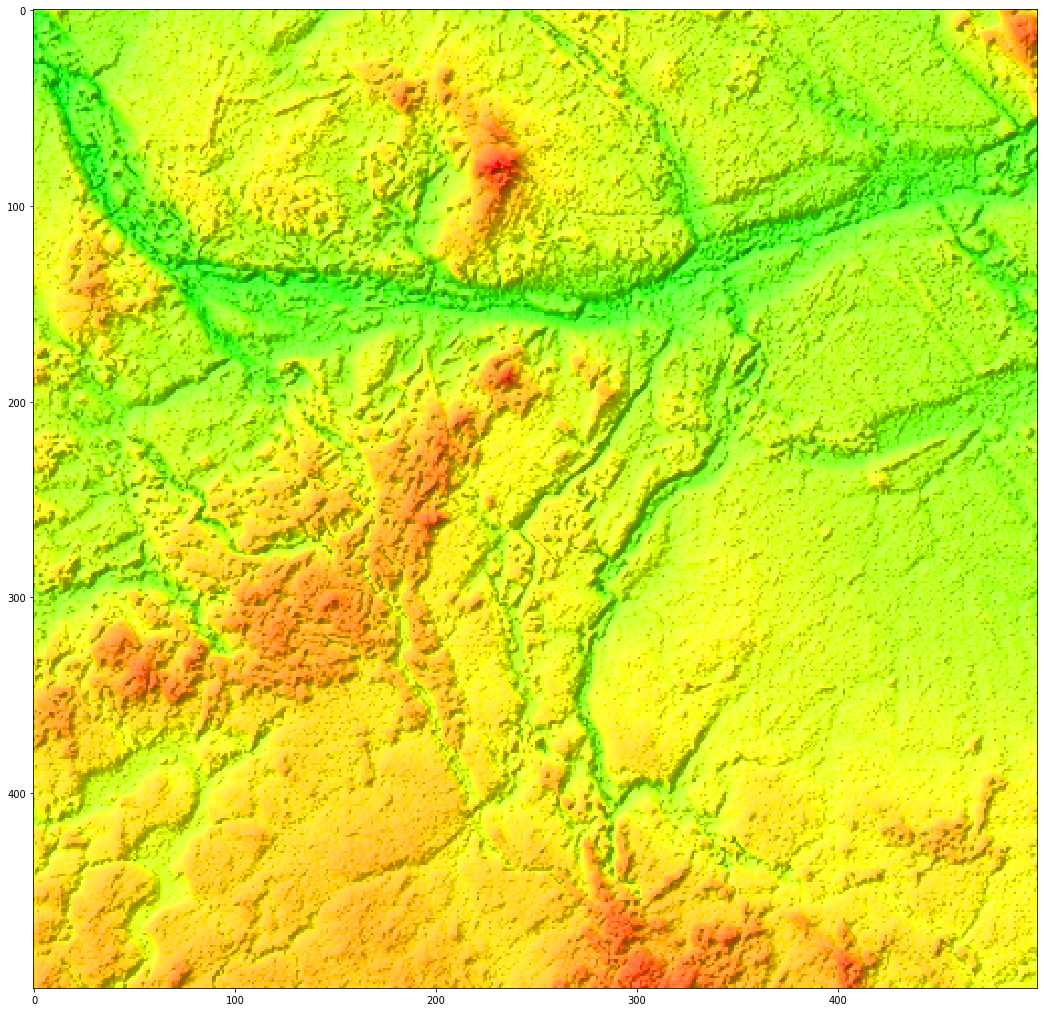

11.950391292572021


In [8]:
def rgb2hsv(r, g, b):
    cmax=max(r, g, b)
    cmin=min(r, g, b)
    dt=cmax-cmin
    
    if (dt==0):
        h=0
    elif (cmax==r):
        h=60*(((g-b)/dt)%6)
    elif (cmax==g):
        h=60*(((b-r)/dt)+2)
    else:
        h=60*(((r-g)/dt)+4)
        
    s=0 if (cmax==0) else dt/cmax
    v=cmax
    return (h, s, v)

def cosa(a, b):
    return ((a[0]*b[0]+a[1]*b[1]+a[2]*b[2])/(math.sqrt(a[0]*a[0]+a[1]*a[1]+a[2]*a[2])*math.sqrt(b[0]*b[0]+b[1]*b[1]+b[2]*b[2])))

t1=time.time()

fig, ax=plt.subplots(1, 1, figsize=(18,18))


sunh=90000000
sunx, suny=-100000000, -100000000

s=np.fromfile(r'/home/sebastian/Downloads/big.dem', sep=" ")
n, m, f=int(s[0]), int(s[1]), s[2]/100
s=s[3:]

s2=s.copy().reshape((n, m))

s=s-s.min()
s=s/s.max()

cd=list_to_dict(['#00FF00', '#FFFF00', '#FF0000'])
z=matplotlib.colors.LinearSegmentedColormap(name='Kappa', segmentdata=cd)
vv=np.asarray([z(x) for x in list(s)])
s=np.reshape(vv, (n, m, 4))
s=s[:,:,:3]
shade=s*0

def sgn(x):
    return (1 if (x>0) else (0 if(x==0) else -1))

for i in range(len(s2)):
    for j in range(len(s2[0])):
        """
        x0, y0, h0=f*i, f*j, s2[i,j] #Point shaded/not shaded
        vsx, vsy, vsh=sunx-f*i, suny-f*j, sunh-s2[i,j]
        if (vsx<0 and i>0):
            x1, y1, h1=f*(i-1), f*j, s2[i-1,j]
        elif(vsx<0):
            x1, y1, h1=f*(i-1), f*j, s2[i,j]
        elif(vsx>0 and i<len(s2)-1):
            x1, y1, h1=f*(i+1), f*j, s2[i+1,j]
        else:
            x1, y1, h1=f*(i+1), f*j, s2[i,j]
        
        
        if (vsy<0 and j>0):
            x2, y2, h2=f*i, f*(j-1), s2[i,j-1]
        elif(vsy<0):
            x2, y2, h2=f*i, f*(j-1), s2[i,j]
        elif(vsy>0 and j<len(s2[0])-1):
            x2, y2, h2=f*i, f*(j+1), s2[i,j+1]
        else:
            x2, y2, h2=f*i, f*(j+1), s2[i,j]
        """
        x0, y0, h0=0, 0, s2[i,j] #Point shaded/not shaded
        vsx, vsy, vsh=sunx-f*i, suny-f*j, sunh-s2[i,j]
        if (vsx<0 and i>0):
            x1, y1, h1=-f, 0, s2[i-1,j]
        elif(vsx<0):
            x1, y1, h1=-f, 0, s2[i,j]
        elif(vsx>0 and i<len(s2)-1):
            x1, y1, h1=f, 0, s2[i+1,j]
        else:
            x1, y1, h1=f, 0, s2[i,j]
        
        
        if (vsy<0 and j>0):
            x2, y2, h2=0, -f, s2[i,j-1]
        elif(vsy<0):
            x2, y2, h2=0, -f, s2[i,j]
        elif(vsy>0 and j<len(s2[0])-1):
            x2, y2, h2=0, f, s2[i,j+1]
        else:
            x2, y2, h2=0, f, s2[i,j]
        
        #v1=np.array([[x0, y0, 1], [x1, y1, 1], [x2, y2, 0]]) old
        v1=np.array([[x0, y0, 1], [x1, y1, 1], [x2, y2, 1]])
        v2=np.array([h0, h1, h2])
        try:
            v3=np.linalg.solve(v1, v2)
        except:
            v3=[0, 0, 0]
            
        pnt=[(x0+x1+x2)/3, (y0+y1+y2)/3, 0]
        pnt[2]=v3[0]*pnt[0]+v3[1]*pnt[1]+v3[2]

        vs=(vsx, vsy, vsh)
        cs=cosa((v3[0], v3[1], -1/f), vs)
        cl=rgb2hsv(*s[i,j])

        sv=min(max(0, cl[1]+0.3*cs), 1)
        sg=min(max(0, cl[2]-0.6*cs), 1)

        
        s[i,j]=np.asarray(hsv2rgb(cl[0], sv, sg))/255
        

ax.imshow(s, aspect='auto')
plt.show()
t2=time.time()
print(t2-t1)

In [ ]:
s=np.fromfile(r'/home/sebastian/Downloads/big.dem', sep=" ")
n, m, f=int(s[0]), int(s[1]), s[2]
s=np.reshape(s[3:], (n, m))
fig, ax=plt.subplots(1, 1, figsize=(18,18))

sunh=1000000
sunx, suny=-100000000, -100000000

cd=list_to_dict(['#00FF00', '#FFFF00', '#FF0000'])
z=matplotlib.colors.LinearSegmentedColormap(name='Kappa', segmentdata=cd)
f=ax.imshow(s, aspect='auto', cmap=z)

szz=s.copy()
plt.show()

In [15]:
print(cosa([1,10], [10,11]))

4.816193126197615


In [ ]:
def rgb2hsv(r, g, b):
    cmax=max(r, g, b)
    cmin=min(r, g, b)
    dt=cmax-cmin
    
    if (dt==0):
        h=0
    elif (cmax==r):
        h=60*(((g-b)/dt)%6)
    elif (cmax==g):
        h=60*(((b-r)/dt)+2)
    else:
        h=60*(((r-g)/dt)+4)
        
    s=0 if (cmax==0) else dt/cmax
    v=cmax
    return (h, s, v)

def cosa(a, b):
    return ((a[0]*b[0]+a[1]*b[1])/(math.sqrt(a[0]*a[0]+a[1]*a[1])*math.sqrt(b[0]*b[0]+b[1]*b[1])))

t1=time.time()

fig, ax=plt.subplots(1, 1, figsize=(18,18))


sunh=1000000
sunx, suny=-1000000, -1000000

s=np.fromfile(r'/home/sebastian/Downloads/big.dem', sep=" ")
n, m, f=int(s[0]), int(s[1]), s[2]/100
s=s[3:]

s2=s.copy().reshape((n, m))

s=s-s.min()
s=s/s.max()

cd=list_to_dict(['#00FF00', '#FFFF00', '#FF0000'])
z=matplotlib.colors.LinearSegmentedColormap(name='Kappa', segmentdata=cd)
vv=np.asarray([z(x) for x in list(s)])
s=np.reshape(vv, (n, m, 4))
s=s[:,:,:3]
shade=s*0

def sgn(x):
    return (1 if (x>0) else (0 if(x==0) else -1))

for i in range(len(s)):
    for j in range(len(s[0])):
        for ij in range(2):
            
            h1=s2[i,j]

            if (ij==0 and i>0):
                h2=s2[i-1,j]
            elif (ij==1 and j>0):
                h2=s2[i,j-1]
            else:
                continue
                
            a=(h2-h1)/f
            #if (a!=0):
            #    a1=-1/a
            #else:
            #    a1=1000000000
            a1=a
            
            h2=sunh
            if (ij==0):
                h1=(s2[i-1,j]+s2[i,j])/2
                a=(h2-h1)/(sunx-i*f)
            else:
                h1=(s2[i,j-1]+s2[i,j])/2
                a=(h2-h1)/(suny-j*f)

            cl=rgb2hsv(*s[i,j])
            cs=cosa([1, a], [1, a1])
            cs=math.acos(cs)
            #print(cs, end=' ')
            cs=cs-math.pi
            cs=-cs
            
            #sv=min(max(0, cl[1]+10*cs**15), 1)
            #sg=min(max(0, cl[2]-5*cs**13), 1)
            
            sv=min(max(0, cl[1]+0.3*cs), 1)
            sg=min(max(0, cl[2]-0.07*cs), 1)
            #if (i<100 and j<100):
            #    print(cs, end=' ')
            
            s[i,j]=np.asarray(hsv2rgb(cl[0], sv, sg))/255
            
ax.imshow(s, aspect='auto')
plt.show()
t2=time.time()
print(t2-t1)